In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import time
# 查询系统可用的 GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# 确保有可用的 GPU 如果没有, 则会报错
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# 设置参数,该段务必在运行jupyter的第一段代码执行，否则会无法初始化成功
# 仅在需要时申请显存空间（程序初始运行时消耗很少的显存，随着程序的运行而动态申请显存）
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### 1.Dataset类相关操作

 Dataset包含了非常丰富的数据转换功能：
 - map(f):对数据集中的每个元素应用函数f，得到一个新的数据集（这部分往往结合进行读写和解码文件，tf.image进行图像处理）
 - shuffle（buffer_size）：将数据集打乱（设定一个固定大小的缓冲区（Buffer),取buffer_size个元素放入，并从缓冲区中随机采样，采样后的数据用后续数据替换）
 - repeat(count):数据集重复次数
 - batch(batch_size)：将数据集分成批次，即对每batch_size个元素，使用tf.stack()在第0维合并，成为一个元素。


In [3]:
help(tf.image.resize)

Help on function resize_images_v2 in module tensorflow.python.ops.image_ops_impl:

resize_images_v2(images, size, method='bilinear', preserve_aspect_ratio=False, antialias=False, name=None)
    Resize `images` to `size` using the specified `method`.
    
    Resized images will be distorted if their original aspect ratio is not
    the same as `size`.  To avoid distortions see
    `tf.image.resize_with_pad`.
    
    >>> image = tf.constant([
    ...  [1,0,0,0,0],
    ...  [0,1,0,0,0],
    ...  [0,0,1,0,0],
    ...  [0,0,0,1,0],
    ...  [0,0,0,0,1],
    ... ])
    >>> # Add "batch" and "channels" dimensions
    >>> image = image[tf.newaxis, ..., tf.newaxis]
    >>> image.shape.as_list()  # [batch, height, width, channels]
    [1, 5, 5, 1]
    >>> tf.image.resize(image, [3,5])[0,...,0].numpy()
    array([[0.6666667, 0.3333333, 0.       , 0.       , 0.       ],
           [0.       , 0.       , 1.       , 0.       , 0.       ],
           [0.       , 0.       , 0.       , 0.3333335, 0.6

In [ ]:
def _decode_and_resize(filename,label):
    image_string = tf.io.read_file(filename) #读取原始文件
    image_decoded = tf.image.decode_jpeg(image_string) #解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256,256]) / 255.0
    return image_resized, label

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_dataset = train_dataset.map(
    map_func = _decode_and_resize,
    num_parallel_calls = tf.data.experimental.AUTOTUNE

)

# 取出前buffer_size个数据放入buffer，并从其中随机采样，采样后的数据用后续数据替换

train_dataset = train_dataset.shuffle(buffer_size = 23000)
train_dataset = train_dataset.repeat(count = 3)
train_dataset = train_dataset.batch(batch_size)

- flat_map(): 将map函数映射到数据集的每一个元素，并将嵌套的Dataset压平
- interleave() : 效果类似flat_map,但可以将不同来源的数据夹在一起
- take()：截取数据集中的前若干个元素

##### flat_map()示例

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([[1,2,3],[4,5,6],[7,8,9]])
dataset_flat = dataset.flat_map(lambda x:tf.data.Dataset.from_tensor_slices(x))

In [5]:
for line in dataset:
    print(line)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)
tf.Tensor([7 8 9], shape=(3,), dtype=int32)


In [6]:
for line in dataset_flat:
    print(line)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [7]:
a = tf.data.Dataset.range(1,6) # ==> [1,2,3,4,5]
# NOTE:New lines indicate 'block' boundaries

b = a.flat_map(lambda x :tf.data.Dataset.from_tensors(x).repeat(6))
for item in b:
    print(item.numpy(), end = ',')

1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,

##### interleave()示例

In [ ]:
interleave(
    map_func, cycle_length = AUTOTUNE, block_length =1, num_parallel_calls = None,
    deterministic = None
)

interleave()是Dataset的类方法，所以interleave是作用在一个Dataset上的。首先该方法会从该Dataset中取出cycle_length个element,然后对这些element apply map_func,得到cycle_length个新的Dataset对象。然后从这些新生成的Dataset对象中取数据，每个Dataset对象一次取block_length个数据。当新生成的某个Dataset的对象取尽时，从原Dataset中再取一个element,然后apply map_func，以此类推。

In [ ]:
filenames = ['./interleave_data/train.csv','./interleave_data/eval.csv',
'./interleave_data/train.csv','./interleave_data/eval.csv']

dataset = tf.data.Dataset.from_tensor_slices(filenames)

def data_func(line):
    line = tf.strings.split(line, sep = ',')
    return line


dataset_1 = dataset.interleave(lambda x: tf.data.TextLineDataset(x).skip(1).map(data_func),
cycle_length=4, block_length = 16
)

for line in dataset_1.take(2):
    print(line)

- filter: 过滤掉某些元素
- zip：将两个长度相同的Dataset横向铰合
- concatenate：将两个Dataset纵向连接
- reduce:执行归并操作

##### zip方法示例

In [9]:
a = tf.data.Dataset.range(1,4) # ===> [1,2,3]
b = tf.data.Dataset.range(4,7) # ===>[4,5,6]
ds = tf.data.Dataset.zip((a,b))

In [10]:
for line in ds:
    print(line)

(<tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(), dtype=int64, numpy=2>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(), dtype=int64, numpy=3>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)


In [11]:
ds = tf.data.Dataset.zip((b,a))
for line in ds:
    print(line)

(<tf.Tensor: shape=(), dtype=int64, numpy=4>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=int64, numpy=5>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(), dtype=int64, numpy=6>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)


##### concatenate方法示例

In [3]:
a = tf.data.Dataset.range(1,4) # ===> [1,2,3]
b = tf.data.Dataset.range(4,7) # ===>[4,5,6]
ds = a.concatenate(b)
for line in ds:
    print(line)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)


#### 2.如何提升Dataset读取性能

- 训练深度学习模型常常非常耗时，模型训练的耗时主要来自于两部分，一部分来自于数据准备，另一部分来自参数迭代。
- 参数迭代过程的耗时通常依赖于GPU来提升，而数据准备过程的耗时则可以通过构建高效的数据管道进行提升。

以下是一些构建高效数据管道的建议:

1. 使用prefetch方法让数据准备和参数迭代两个过程相互并行

2. 使用interleave方法可以让数据读取过程多进程执行，并将不同来源数据夹在一起

3. 使用map时设置 num_parallel_calls 让数据转换过程多进程执行

4. 使用cache方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形

#### prefetch方法
原始方法执行，可以看到执行训练步骤涉及：
- 打开文件(如果尚未打开)
- 从文件中获取数据条目
- 使用数据进行训练

![prefetch_1](./markdown_pics/prefetch_1.png)

![优化后的方法](./markdown_pics/prefetch_优化后的方法.png)

![prefetch注意事项](./markdown_pics/prefetch注意事项.png)

#### interleave 方法

![interleave](./markdown_pics/interleave介绍.png)

![interleave加载方法](./markdown_pics/interleave介绍_加载方法.png)

#### map多进程执行

![map多进程](./markdown_pics/map多进程执行.png)

![map多进程](./markdown_pics/map多进程执行办法.png)

![cache方法](./markdown_pics/cache方法.png)

#### 3.案例讲解
- 猫狗图片分类

In [16]:
#### 对kaggle原始数据集执行划分训练集和验证集，执行如下两个代码

# import shutil
# os.chdir('./data/dogs-vs-cats/')

# # 对文件夹中的数据执行移动
# for i in os.listdir('./train'):
#     if i[0:3] == 'cat':
#         shutil.move(f'./train/{i}','./cats')
        

# for i in os.listdir('./train'):
#     if i[0:3] == 'dog':
#         shutil.move(f'./train/{i}','./dogs')

In [25]:
# import re
# import shutil
# # 对文件夹中的数据执行移动
# for i in os.listdir('./dogs'):
#     if re.search('[0-9]{5}',str(i).split('.')[-2]): # 对10000-12499的图片执行移动
#         shutil.move(f'./dogs/{i}','./valid/dogs')


# for i in os.listdir('./cats'):
#     if re.search('[0-9]{5}',str(i).split('.')[-2]): # 对10000-12499的图片执行移动
#         shutil.move(f'./cats/{i}','./valid/cats')

# for i in os.listdir('./cats'):
#     shutil.move(f'./cats/{i}','./train/cats')

# for i in os.listdir('./dogs'):
#     shutil.move(f'./dogs/{i}','./train/dogs')


In [17]:
!ls

cats  dogs  sampleSubmission.csv  test1  train	valid


In [56]:
os.chdir('/home/hp/git/learningzone/huangpei/eat_tensorflow2_in_30_days/')
data_dir = '/share/data/tutorial/cat_dog/datasets'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'

In [57]:
# 构建训练数据集
train_cat_filenames = tf.constant([train_cats_dir + filename for filename in os.listdir(train_cats_dir)][:1000])

train_dog_filenames = tf.constant([train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)][:1000])

train_filenames = tf.concat([train_cat_filenames,train_dog_filenames],axis = -1)

train_labels = tf.concat([
    tf.zeros(train_cat_filenames.shape,dtype = tf.int32),
    tf.ones(train_dog_filenames.shape,dtype = tf.int32)],
    axis = -1
)

In [58]:
type(train_cat_filenames)

tensorflow.python.framework.ops.EagerTensor

In [59]:
train_cat_filenames[0:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'/share/data/tutorial/cat_dog/datasets/train/cats/cat.5781.jpg',
       b'/share/data/tutorial/cat_dog/datasets/train/cats/cat.11310.jpg',
       b'/share/data/tutorial/cat_dog/datasets/train/cats/cat.914.jpg',
       b'/share/data/tutorial/cat_dog/datasets/train/cats/cat.9677.jpg',
       b'/share/data/tutorial/cat_dog/datasets/train/cats/cat.8813.jpg'],
      dtype=object)>

In [60]:
# 构建训练集
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)   # 读取原始图片
    image_decoded = tf.image.decode_jpeg(image_string) # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256,256]) / 255.0
    return image_resized, label

In [61]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames,train_labels))

In [62]:
train_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [63]:
def benchmark(dataset, num_epochs = 1):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # 执行训练步骤
            time.sleep(0.01)
    tf.print('Execution time:', time.perf_counter() - start_time)


#### prefetch方法

In [64]:
benchmark(
    train_dataset.map(
        map_func = _decode_and_resize,
        num_parallel_calls = tf.data.experimental.AUTOTUNE
    ), num_epochs = 1
)

Execution time: 21.48777252342552


In [65]:
benchmark(
    train_dataset.map(
        map_func = _decode_and_resize,
        num_parallel_calls = tf.data.experimental.AUTOTUNE
    ).prefetch(tf.data.experimental.AUTOTUNE)
    , num_epochs = 1
)

Execution time: 21.47324484307319


#### interleave 方法

In [66]:
filenames = ['./data/interleave_data/train.csv','./data/interleave_data/eval.csv',
'./data/interleave_data/train.csv','./data/interleave_data/eval.csv']

dataset = tf.data.Dataset.from_tensor_slices(filenames)

def data_func(line):
    line = tf.strings.split(line, sep = ',')
    return line


dataset_1 = dataset.interleave(lambda x: tf.data.TextLineDataset(x).skip(1).map(data_func),
cycle_length=4, block_length = 16
)

for line in dataset_1.take(2):
    print(line)

tf.Tensor(
[b'0' b'male' b'22.0' b'1' b'0' b'7.25' b'Third' b'unknown' b'Southampton'
 b'n'], shape=(10,), dtype=string)
tf.Tensor(
[b'1' b'female' b'38.0' b'1' b'0' b'71.2833' b'First' b'C' b'Cherbourg'
 b'n'], shape=(10,), dtype=string)


In [67]:
benchmark(dataset_1, num_epochs = 1)

Execution time: 19.670941513963044


In [68]:
dataset_2 = dataset.interleave(
    lambda x: tf.data.TextLineDataset(x).skip(1).map(data_func), num_parallel_calls = tf.data.experimental.AUTOTUNE,
    cycle_length = 4, block_length = 16
)

Cause: could not parse the source code:

    lambda x: tf.data.TextLineDataset(x).skip(1).map(data_func), num_parallel_calls = tf.data.experimental.AUTOTUNE,

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

    lambda x: tf.data.TextLineDataset(x).skip(1).map(data_func), num_parallel_calls = tf.data.experimental.AUTOTUNE,

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [69]:
benchmark(dataset_2, num_epochs = 1)


Execution time: 18.92460592929274


#### map方法

In [70]:
benchmark(
    train_dataset.map(
        map_func = _decode_and_resize,
        num_parallel_calls= tf.data.experimental.AUTOTUNE
    )
)

Execution time: 21.512921785004437


In [71]:
benchmark(
    train_dataset.map(
        map_func = _decode_and_resize
    )
)

Execution time: 30.211077282205224


#### cache方法

In [72]:
benchmark(
    train_dataset.map(
        map_func = _decode_and_resize,
        num_parallel_calls= tf.data.experimental.AUTOTUNE
    ),
    num_epochs=2
)

Execution time: 42.831294492818415


In [73]:
benchmark(
    train_dataset.map(
        map_func = _decode_and_resize,
        num_parallel_calls= tf.data.experimental.AUTOTUNE
    ).cache(),
    num_epochs=2
)

Execution time: 42.913999947719276


### kaggle猫狗图像识别整合方法演示案例

In [79]:
os.chdir('/home/hp/git/learningzone/huangpei/eat_tensorflow2_in_30_days/')
data_dir = '/share/data/tutorial/cat_dog/datasets'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'

In [112]:
# 构建训练数据集
train_cat_filenames = tf.constant([train_cats_dir + filename for filename in os.listdir(train_cats_dir)])

train_dog_filenames = tf.constant([train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)])

train_filenames = tf.concat([train_cat_filenames,train_dog_filenames],axis = -1)

# 构建一个标签
train_labels = tf.concat([
    tf.zeros(train_cat_filenames.shape,dtype = tf.int32),
    tf.ones(train_dog_filenames.shape,dtype = tf.int32)],
    axis = -1
)

In [113]:
train_cat_filenames.shape

TensorShape([11500])

In [114]:
train_labels

<tf.Tensor: shape=(23000,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 1, 1], dtype=int32)>

In [118]:
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)            # 读取原始文件
    image_decoded = tf.image.decode_jpeg(image_string)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0
    return image_resized, label

In [119]:
tf.constant(data_dir + '/train/cats/cat.0.jpg')

<tf.Tensor: shape=(), dtype=string, numpy=b'/share/data/tutorial/cat_dog/datasets/train/cats/cat.0.jpg'>

In [120]:
# 对函数的可执行做测试,查看是否可以正常将图片转换为张量
_decode_and_resize(tf.constant(data_dir + '/train/cats/cat.0.jpg'), tf.constant(0))

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.7940257 , 0.64108455, 0.3391238 ],
         [0.80168504, 0.64874387, 0.3467831 ],
         [0.8132659 , 0.66032475, 0.35836396],
         ...,
         [0.9532872 , 0.7964244 , 0.46309108],
         [0.9428615 , 0.7938419 , 0.47619486],
         [0.9352022 , 0.7861826 , 0.46853554]],
 
        [[0.7940257 , 0.64108455, 0.3391238 ],
         [0.80168504, 0.64874387, 0.3467831 ],
         [0.8132659 , 0.66032475, 0.35836396],
         ...,
         [0.95611584, 0.7992531 , 0.46591976],
         [0.9428615 , 0.7938419 , 0.47619486],
         [0.9352022 , 0.7861826 , 0.46853554]],
 
        [[0.7940257 , 0.64108455, 0.3391238 ],
         [0.80168504, 0.64874387, 0.3467831 ],
         [0.8132659 , 0.66032475, 0.35836396],
         ...,
         [0.95626533, 0.7985458 , 0.4725622 ],
         [0.94678307, 0.79776347, 0.48011643],
         [0.93912375, 0.79010415, 0.4724571 ]],
 
        ...,
 
        [[0.60059744, 0.4790288 

In [121]:
img,label = _decode_and_resize(tf.constant(data_dir + '/train/cats/cat.0.jpg'), tf.constant(0))

In [122]:
img.shape

TensorShape([256, 256, 3])

In [123]:
label.shape

TensorShape([])

In [124]:
import matplotlib.pyplot as plt

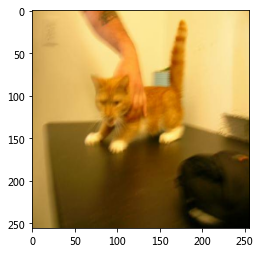

In [125]:
plt.imshow(img.numpy())

In [126]:
np.trunc((img.numpy() * 255))
# 从这里可以看出，作为3个通道的彩色图像，每一个中括号都表示一个像素点，然后再外层的中括号，表示了第一横排的256个像素表示，下一个中括号层表示了第二横排的256个像素的RGB表示，然后


array([[[202., 163.,  86.],
        [204., 165.,  88.],
        [207., 168.,  91.],
        ...,
        [243., 203., 118.],
        [240., 202., 121.],
        [238., 200., 119.]],

       [[202., 163.,  86.],
        [204., 165.,  88.],
        [207., 168.,  91.],
        ...,
        [243., 203., 118.],
        [240., 202., 121.],
        [238., 200., 119.]],

       [[202., 163.,  86.],
        [204., 165.,  88.],
        [207., 168.,  91.],
        ...,
        [243., 203., 120.],
        [241., 203., 122.],
        [239., 201., 120.]],

       ...,

       [[153., 122.,  55.],
        [153., 122.,  55.],
        [154., 123.,  56.],
        ...,
        [  2.,   3.,   0.],
        [  2.,   3.,   0.],
        [  2.,   3.,   0.]],

       [[151., 120.,  53.],
        [152., 121.,  54.],
        [153., 122.,  55.],
        ...,
        [  1.,   2.,   0.],
        [  1.,   2.,   0.],
        [  1.,   2.,   0.]],

       [[150., 119.,  52.],
        [151., 120.,  53.],
        [152., 1

In [127]:
# 构建训练集
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)   # 读取原始图片
    image_decoded = tf.image.decode_jpeg(image_string) # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256,256]) / 255.0  # 图片大小不一致，此处做处理
    return image_resized, label



batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames,train_labels))

# 名字
train_dataset = train_dataset.map(
    map_func = _decode_and_resize,
    num_parallel_calls = tf.data.experimental.AUTOTUNE
) 



# 取出前buffer_size个数据放入buffer，并从其中随机采样，采样后的数据用后续数据替换

train_dataset = train_dataset.shuffle(buffer_size = 23000)

train_dataset = train_dataset.repeat(count = 3)

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [128]:
# 构建测试数据集
test_cat_filenames = tf.constant([])

In [132]:
# 构建训练数据集
test_cat_filenames = tf.constant([test_cats_dir + filename for filename in os.listdir(test_cats_dir)])

test_dog_filenames = tf.constant([test_dogs_dir + filename for filename in os.listdir(test_dogs_dir)])

test_filenames = tf.concat([test_cat_filenames,test_dog_filenames],axis = -1)

# 构建一个标签
test_labels = tf.concat([
    tf.zeros(test_cat_filenames.shape,dtype = tf.int32),
    tf.ones(test_dog_filenames.shape,dtype = tf.int32)],
    axis = -1
)


test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames,test_labels))
test_dataset = test_dataset.map(_decode_and_resize)
test_dataset = test_dataset.batch(batch_size)

In [134]:
# 设计神经网络模型,卷积和池化
class CNNModel(tf.keras.models.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,3, activation= 'relu')
        self.maxpool1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(32,5,activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(64,activation='relu')
        self.d2 = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

In [136]:
learning_rate = 0.001
model = CNNModel()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)

train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [138]:
EPOCHS = 10
for epoch in range(EPOCHS):
    # 在下一个epoch开始的时候，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()

    test_loss.reset_states()
    test_accuracy.reset_states()
    

    for images, labels in train_dataset:
        train_step(images, labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(
        epoch + 1,
        train_loss.result(),
        train_accuracy.result() * 100,
        test_loss.result(),
        test_accuracy.result() * 100
    ))

Epoch 1, Loss: 0.0038154656067490578, Accuracy: 99.90869903564453, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 2, Loss: 0.0004077258345205337, Accuracy: 99.98551177978516, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 3, Loss: 0.00012602763308677822, Accuracy: 99.99565124511719, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 4, Loss: 0.00011560374696273357, Accuracy: 99.99565124511719, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 5, Loss: 0.00011036585783585906, Accuracy: 99.99565124511719, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 6, Loss: 0.00010686573659768328, Accuracy: 99.99565124511719, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 7, Loss: 0.00010447353270137683, Accuracy: 99.99565124511719, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 8, Loss: 0.0001027499747578986, Accuracy: 99.99565124511719, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 9, Loss: 0.018875831738114357, Accuracy: 99.58840942382812, Test Loss: 0.0, Test Accuracy: 0.0
Epoch 10, Loss: 0.00605793995782733, Accuracy: 99.87826538085938, Test Loss: 0

In [141]:
os.chdir('/home/hp/git/learningzone/huangpei/eat_tensorflow2_in_30_days/')

#### 训练中显卡使用情况

![显存使用情况](./markdown_pics/显卡资源使用情况.png)

#### 训练完毕显卡闲置时情况


![显存使用情况](./markdown_pics/未参与训练情况下的GPU使用情况.png)
